In [3]:
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [4]:
#Suppressing Warnings for better looking output if desired
import warnings
warnings.filterwarnings('ignore')

Data Grabbing Function

In [5]:
#Returns player info for past 50 games before the input date, from StatsMuse
def get_player_data(name, date):
    # can replace name to any player name, can change date to match any games before that date
    url = 'https://www.statmuse.com/nba/ask?q=' + name.lower().replace(' ', '+') + '+off+rating%2C+usage%2C+true+game+log+before+' + date.replace('/', '%2F')

    # get page content
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content using Pandas read_html function
        tables = pd.read_html(response.text)

        # assumes we want only the first 25 rows of table since statmuse only shows 25 rows for free
        df = tables[0].head(25)
        df = df.filter(items=["NAME", "DATE", "OPP", "ORTG", "PTS", "USG%", "TS%", "FGA", "FGM", "MIN"])

        # original columns (could save any of these other cols)
        """ ['Unnamed: 0', 'NAME', 'DATE', 'ORTG', 'USG%', 'TS%', 'TM', 'Unnamed: 7',
           'OPP', 'MIN', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'FGM', 'FGA',
           'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'PF', '+/-']  """


        earliest_date = df.iloc[-1]['DATE']


    url2 = 'https://www.statmuse.com/nba/ask?q=' + name.lower().replace(' ', '+') + '+off+rating%2C+usage%2C+true+game+log+before+' + earliest_date.replace('/', '%2F')

    # get page content
    response = requests.get(url2)
    tables = pd.read_html(response.text)
    df2 = tables[0].head(25)
    df2 = df2.filter(items=["NAME", "DATE", "OPP", "ORTG", "PTS", "USG%", "TS%", "FGA", "FGM", "MIN"])

    # merge dataframes
    final_df = pd.concat([df, df2], ignore_index=True)

    # filling NaNs
    final_df = final_df.fillna({"NAME": "ERROR", "DATE": "ERROR", "OPP": "ERROR", "ORTG": final_df.loc[:,'ORTG'].mean(), \
                            "PTS": final_df.loc[:,'PTS'].mean(), "USG%": final_df.loc[:,'USG%'].mean(), \
                            "TS%": final_df.loc[:,'TS%'].mean(), "FGA": final_df.loc[:,'FGA'].mean(),\
                            "FGM": final_df.loc[:,'FGM'].mean(), "MIN": final_df.loc[:,'MIN'].mean()})

    return final_df

In [7]:
name = 'Aaron Holiday'
date = '04/12/24'
print(get_player_data(name, date))
#print(get_player_data(name, date).loc[:, 'PTS'].to_numpy())

             NAME        DATE  OPP        ORTG   PTS  USG%      TS%   FGA  \
0   Aaron Holiday   4/11/2024  UTA  151.500000   6.0  18.3   60.000   5.0   
1   Aaron Holiday    4/7/2024  DAL   80.500000   3.0   9.5   75.000   2.0   
2   Aaron Holiday    4/5/2024  MIA   30.200000   0.0   9.4    0.000   2.0   
3   Aaron Holiday    4/4/2024  GSW  154.900000   6.0   9.8   75.000   4.0   
4   Aaron Holiday    4/2/2024  MIN   95.200000   0.0   7.4    0.000   1.0   
5   Aaron Holiday   3/31/2024  DAL  131.100000  16.0  24.7   67.300  11.0   
6   Aaron Holiday   3/29/2024  UTA   19.200000   0.0  12.3    0.000   2.0   
7   Aaron Holiday   3/27/2024  OKC  122.700000   4.0  19.0   40.000   5.0   
8   Aaron Holiday   3/25/2024  POR  157.900000  11.0  15.6   63.700   6.0   
9   Aaron Holiday   3/23/2024  UTA  132.100000   7.0  14.9   50.000   7.0   
10  Aaron Holiday   3/21/2024  CHI  182.000000  15.0  17.8  109.000   6.0   
11  Aaron Holiday   3/19/2024  WAS  133.000000   7.0  15.8   44.400   7.0   

Defensive Matchup Grabbing

In [8]:
#Returns defensive points allowed data given a position
def get_def_mc(pos):
    loc = "matchups/" + pos.lower() + ".csv"
    team_data = pd.read_csv(loc)
    output = {}
    for index, row in team_data.iterrows():
        output[row[0]] = row[1]
    return output

In [9]:
get_def_mc("pf")

{'UTA': 25.7,
 'WAS': 25.42,
 'TOR': 24.78,
 'IND': 26.07,
 'ATL': 24.71,
 'GSW': 24.24,
 'DET': 24.64,
 'CHA': 24.55,
 'DAL': 24.75,
 'HOU': 23.02,
 'LAL': 24.78,
 'SAC': 25.05,
 'MEM': 23.14,
 'PHX': 24.49,
 'OKC': 22.98,
 'DEN': 23.31,
 'CHI': 23.12,
 'SAS': 22.52,
 'POR': 22.8,
 'NOP': 22.94,
 'CLE': 23.72,
 'PHI': 22.42,
 'MIL': 23.41,
 'LAC': 21.95,
 'BKN': 22.44,
 'NYK': 22.87,
 'MIA': 21.47,
 'MIN': 21.13,
 'ORL': 20.44,
 'BOS': 20.31}

Model

In [93]:
def model(name, position, date, opponent, projection, demo_mode=False):
    # Data for average points allowed by each team against players of the same position
    team_points_allowed = get_def_mc(position)

    # Get the average points allowed by MEM against players of the same position

    player_data = get_player_data(name, date)

    point = player_data.loc[:, 'PTS'].to_numpy()
    true = player_data.loc[:, 'TS%'].to_numpy()
    usage = player_data.loc[:, 'USG%'].to_numpy()
    fga = player_data.loc[:, 'FGA'].to_numpy()
    fgm = player_data.loc[:, 'FGM'].to_numpy()
    off_rat = player_data.loc[:, 'ORTG'].to_numpy()
    min = player_data.loc[:, 'MIN'].to_numpy()
    opponent_teams = player_data.loc[:, 'OPP'].to_numpy()
    
    mean_point = np.mean(point)
    std_dev_point = np.std(point)
    mean_usage = np.mean(usage)
    std_dev_usage = np.std(usage)
    mean_true = np.mean(true)
    std_dev_true = np.std(true)
    mean_fga = np.mean(fga)
    std_dev_fga = np.std(fga)
    mean_fgm = np.mean(fgm)
    std_dev_fgm = np.std(fgm)
    mean_off_rat = np.mean(off_rat)
    std_off_rat = np.std(off_rat)
    mean_min = np.mean(min)
    std_min = np.std(min)

    # Number of simulations

    num_simulations = 10000
    actual_range = int(num_simulations/ len(point))
    # Arrays to store simulated results
    simulated_points = np.zeros((actual_range, len(point)))

    # Calculate R-squared values for each variable
    r2_values = []
    for variable in [point, usage, true, fga, fgm, off_rat, min]:
        X = np.array(variable).reshape(-1, 1)
        linear_model = LinearRegression()
        linear_model.fit(X, point)
        y_pred = linear_model.predict(X)
        r2_values.append(r2_score(point, y_pred))

    # Normalize R-squared values to create custom weights
    weights = np.array(r2_values) / np.sum(r2_values)

    # Simulate linear regression and prediction for points
    for i in range(actual_range):
        # Add some random noise to the true, usage, and point values to simulate variability
        simulated_true = np.array(true) + np.random.normal(mean_true, std_dev_true, len(true))
        simulated_usage = np.array(usage) + np.random.normal(mean_usage, std_dev_usage, len(usage))
        simulated_point = np.array(point) + np.random.normal(mean_point, std_dev_point, len(point))
        simulated_fga = np.array(fga) + np.random.normal(mean_fga, std_dev_fga, len(fga))
        simulated_fgm = np.array(fgm) + np.random.normal(mean_fgm, std_dev_fgm, len(fgm))
        simulated_off_rat = np.array(off_rat) + np.random.normal(mean_off_rat, std_off_rat, len(off_rat))
        simulated_min = np.array(min) + np.random.normal(mean_min, std_min,len(min))
        # Perform linear regression for points with custom weights
        X = np.array([simulated_true, simulated_usage, simulated_point, simulated_fga, simulated_fgm, simulated_off_rat, simulated_min]).T
        linear_model = LinearRegression()
    
        # Apply custom weights to each variable
        X_weighted = X * weights
    
        # Fit the model and predict points
        linear_model.fit(X_weighted, point)
        simulated_points[i, :] = linear_model.predict(X_weighted)

    # Now simulated_points has the shape (num_simulations, len(point))
    total_points_allowed = sum(team_points_allowed.values())
    mean_points_allowed = total_points_allowed / len(team_points_allowed)
    adjusted_matchup = team_points_allowed[opponent]/ mean_points_allowed
    simulated_points *= adjusted_matchup

    # Print the result


    median_predicted_points = np.median(simulated_points)
    if demo_mode == False:
        print(f"Median value of predicted points: {median_predicted_points:.2f}")

    mean_predicted_points = np.mean(simulated_points)
    if demo_mode == False:
        print(f"Mean value of predicted points: {mean_predicted_points:.2f}")

    max_predicted_points = np.max(simulated_points)
    if demo_mode == False:
        print(f"Ceiling value of predicted points: {max_predicted_points:.2f}")

    min_predicted_points = np.min(simulated_points)
    if demo_mode == False:
        print(f"Floor value of predicted points: {min_predicted_points:.2f}")



    #Plot the distribution of weights
    if demo_mode == False:
        plt.hist(simulated_points.flatten(), bins=30, color='blue', alpha=0.7)
        plt.title(name + ' Distribution of Predicted Points')
        plt.xlabel('Predicted Points')
        plt.ylabel('Frequency')
    
    #Finding over/under chances
    num_over = 0
    num_under = 0
    num_push = 0
    for set in simulated_points:
        for num in set:
            if num > projection:
                num_over = num_over + 1
            elif num < projection:
                num_under = num_under + 1
            else:
                num_push = num_push + 1

    over_chance = 100 * num_over/(num_over + num_under + num_push)
    under_chance = 100 * num_under/(num_over + num_under + num_push)

    if demo_mode == False:
        print(f"Over Odds: {over_chance}")
        print(f"Under Odds: {under_chance}")

    #Giving return to demo
    if demo_mode == True:
        return (mean_predicted_points, over_chance, under_chance)

Median value of predicted points: 26.08
Mean value of predicted points: 25.60
Ceiling value of predicted points: 62.65
Floor value of predicted points: -3.00
Over Odds: 57.19
Under Odds: 42.81


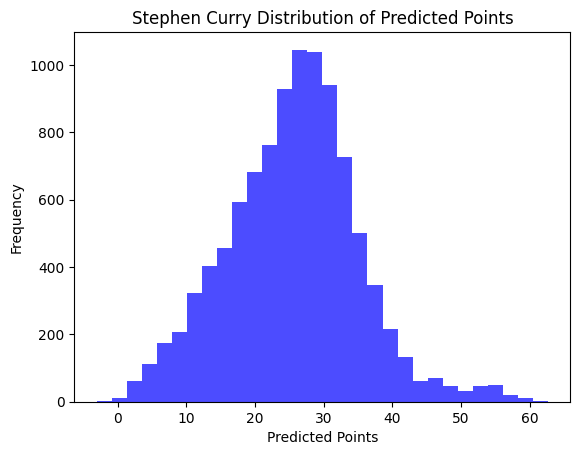

In [99]:
#Example run of model for an individual player
model("Stephen Curry", "PG", "4/12/24", "NOP", 24.5)

Demo

In [87]:
import datetime

In [95]:
#Running model for 100 players, projecting for their points scored for the 4/12/2024 games
#Extracting info from input file
demo_input = pd.read_csv("demo_input.csv")

BCE_losses = []
correct_over_under = 0
ses = []

valid_over_under = 0 #Count for non-push over/under outcomes

#projection = 30 #Threshold for over/under bets

for index, row in demo_input.iterrows():
    name = row[0]
    date = row[1]
    opponent = row[3]
    actual_score = row[4]
    position = row[5]
    prop = row[6] #Threshold for over/under bets

    #Running model to get point prediction w/ over under chances
    (prediction, over, under) = model(name, position, date, opponent, prop, demo_mode=True)

    #Calculating point prediction error using model prediction and actual points scored value
    ses = ses + [(actual_score - prediction)*(actual_score - prediction)]

    #Logging if over/under prediction from model was correct and calculating BCE Loss
    #Skipping this metric for players that yielded a push rather than an over or under
    if actual_score != prop:
        valid_over_under = valid_over_under + 1

        if prediction > prop:
            #over
            over_under_result = 1
        elif prediction < prop:
            #under
            over_under_result = 0

        if (((over_under_result == 1) & (prediction > actual_score)) or ((over_under_result == 0) & (prediction < actual_score))):
            correct_over_under = correct_over_under + 1
        BCE_losses = BCE_losses + [(over_under_result*(np.log(over/100)) + (1 - over_under_result)*(np.log(1 - over/100)))]

#Reporting MSE, BCE Loss, Over/Under Accuracy
mse = np.sum(ses)/demo_input.shape[0]
BCE_loss = np.sum(BCE_losses)/-demo_input.shape[0]
over_under_accuracy = correct_over_under/valid_over_under
print(valid_over_under)
print(correct_over_under)

100
65


In [109]:
#this code only counts for players who have more than a 10% edge against the implied probability

demo_input = pd.read_csv("demo_input.csv")

BCE_losses = []
correct_over_under = 0
ses = []

valid_over_under = 0 
for index, row in demo_input.iterrows():
    name = row[0]
    date = row[1]
    opponent = row[3]
    actual_score = row[4]
    position = row[5]
    prop = row[6] #Threshold for over/under bets

    # Running model to get point prediction w/ over under chances
    (prediction, over, under) = model(name, position, date, opponent, prop, demo_mode=True)

    # Calculating point prediction error using model prediction and actual points scored value
    ses = ses + [(actual_score - prediction)*(actual_score - prediction)]

    percent_dif = prediction / prop

    # Logging if over/under prediction from model was correct and calculating BCE Loss
    # Skipping this metric for players that yielded a push rather than an over or under
    if ((actual_score != prop) and ((over >= 62.38) or (under >= 62.38))):
        valid_over_under = valid_over_under + 1

        if actual_score != prop:
            if prediction > prop:
                # over
                over_under_result = 1
            elif prediction < prop:
                # under
                over_under_result = 0

            if (((over_under_result == 1) & (prediction > actual_score)) or ((over_under_result == 0) & (prediction < actual_score))):
                correct_over_under = correct_over_under + 1
            BCE_losses = BCE_losses + [(over_under_result*(np.log(over/100)) + (1 - over_under_result)*(np.log(1 - over/100)))]
    

# Reporting MSE, BCE Loss, Over/Under Accuracy
mse = np.sum(ses) / demo_input.shape[0]
BCE_loss = np.sum(BCE_losses) / -demo_input.shape[0]
over_under_accuracy = correct_over_under / valid_over_under

60
48


In [104]:
#Saving results from demo in CSVs
demo_ses = pd.DataFrame(ses, columns=['ses'])
demo_ses.to_csv("outputs\demo_ses.csv")

demo_bce = pd.DataFrame(BCE_losses, columns=['bces'])
demo_bce.to_csv("outputs\demo_bce.csv")

demo_stats = pd.DataFrame([[mse, BCE_loss, over_under_accuracy]], columns=['mse', 'bce_loss', 'over_under_acc'])
demo_stats.to_csv("outputs\demo_stats.csv")

In [105]:
#Printing stats resulting from demo
mse_output = pd.read_csv("outputs\demo_stats.csv").loc[0, 'mse']
print(f"Mean Squared Error of Score Prediction: {mse_output}")

BCE_loss_output = pd.read_csv("outputs\demo_stats.csv").loc[0, 'bce_loss']
print(f"Binary Cross Entropy Loss for Over/Under Probabilities: {BCE_loss_output}")

over_under_accuracy_output = pd.read_csv("outputs\demo_stats.csv").loc[0, 'over_under_acc']
print(f"Over/Under Accuracy:{over_under_accuracy_output*100}%")

Mean Squared Error of Score Prediction: 70.84669250672987
Binary Cross Entropy Loss for Over/Under Probabilities: 0.2351513385990547
Over/Under Accuracy:77.63157894736842%


Text(0, 0.5, 'Frequency')

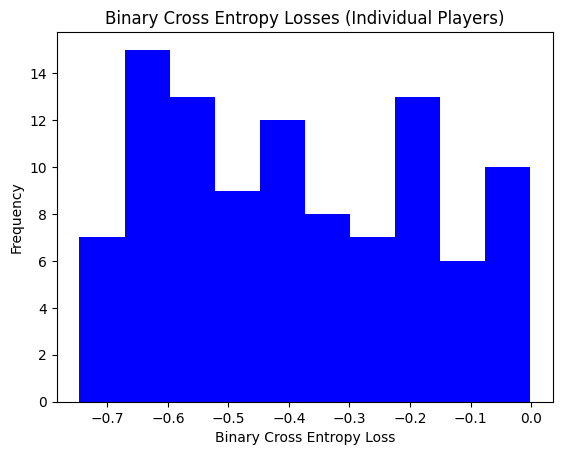

In [78]:
#Graphing BCE losses for individual players
BCE_losses_graphing = pd.read_csv("outputs\demo_bce.csv")
plt.hist(BCE_losses_graphing.loc[:,'bces'], bins=10, color='blue')
plt.title('Binary Cross Entropy Losses (Individual Players)')
plt.xlabel('Binary Cross Entropy Loss')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

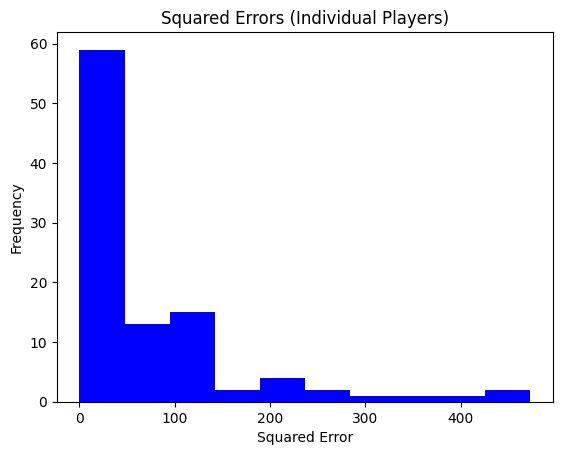

In [79]:
#Graphing SEs for individual players
ses_graphing = pd.read_csv("outputs\demo_ses.csv")
plt.hist(ses_graphing.loc[:,'ses'], bins=10, color='blue')
plt.title('Squared Errors (Individual Players)')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')